# 원티드 스크래이핑
- 목록 페이지가 스크롤을 내릴때마다 공고 목록 일정 개수가 추가 되는 방식이라 selenium을 사용하여서 스크롤을 내리며 목록 스크래이핑 진행
- 대부분 공고문에 자격요건, 우대사항에 스킬에 관련된 내용이 들어가있어 전체 공고문 중 자격요건, 우대사항 부분만 스크래이핑 하였습니다.
- mongodb에는 wanted db 생성 후 da_jobs(분석가), ds_jobs(사이언티스트), de_jobs(엔지니어) 3개의 collection을 생성 후 저장하였습니다.
```
collection document는 {회사명 : 기업이름, 자격요건 : 내용 ,우대사항 : 내용} 으로 저장하였습니다.
```
- 잡코리아는 이미 키워드로 분리되어 있지만 원티드의 경우 자격요건, 우대사항 부분의 키워드를 추출해내고 분석하는 과정이 필요할 것으로 예상됩니다.

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup
import urllib
import time
import pymongo

In [ ]:
# 보안설정 후 admin 계정인 hslee 이용하여 mongodb 접속
client = pymongo.MongoClient("mongodb://{ID}:{PWD}@{HOST}:{PORT}")
client

In [ ]:
# db 선택(없으면 자동 생성)
db = client.wanted
db

In [ ]:
def get_chrome_driver():
    # 1. 크롬 옵션 세팅
    chrome_options = webdriver.ChromeOptions()

    # 2. driver 생성하기
    driver = webdriver.Chrome(
        service=Service(ChromeDriverManager().install()), # 가장 많이 바뀐 부분
        options=chrome_options
    )
    
    return driver

In [ ]:
# 링크 리스트를 찾아내기 위한 준비과정
# driver와 직무를 파라미터로 작동
def search_job_scroll(driver, job):
    job_for_search = urllib.parse.quote(job)
    # 검색 버튼 클릭
    driver.find_element(By.CSS_SELECTOR,"button.searchButton").click()
    # 검색어 입력
    driver.find_element(By.CSS_SELECTOR,"div.SearchBar_SearchBar_container__kpoXq > form > input").send_keys(f"{job}")
    # 엔터
    driver.find_element(By.CSS_SELECTOR,"div.SearchBar_SearchBar_container__kpoXq > form > input").send_keys(Keys.RETURN)

    # 스크롤을 아래로 내릴때마 공고 리스트가 추가되는 방식이기 떄문에
    # 링크 크롤링 진행 전 스크롤 내리기
    for scroll in range(1100,28000,950):
        driver.execute_script(f"window.scrollTo(0, {scroll})")
        # 너무 빨리 내리면 추가 목록이 생기기 전에 스크롤 내리는 과정이 끝나버린다. 1초로 스크롤 텀 주기
        time.sleep(1)

# 데이터 엔지니어

In [ ]:
driver = get_chrome_driver()
driver.get("https://www.wanted.co.kr/")
search_job_scroll(driver, "데이터 엔지니어")

# 공고 리스트 뽑아내기 
# WebElement 객체로 저장된다.
postings = driver.find_elements(
    By.CSS_SELECTOR,
    'ul.clearfix > li'
)

# 공고 리스트에서 innerHTML 추출
post_list = []
for post in postings:
    post_list.append((post).get_attribute("innerHTML"))

# 각 공고의 innerHTML 파싱 진행
po_list = []
for po in post_list:
    po_list.append(BeautifulSoup(po,'html.parser'))

# 파싱된 리스트에서 각 공고 링크만 추출
links = []
for p in po_list:
    temp_link = p.select_one("div.Card_className__u5rsb > a")['href']
    links.append(f"https://www.wanted.co.kr{temp_link}")

print(len(links))


doc_list = []

for link in links:
    driver.get(f"{link}")
    
    try:
        # 회사명
        company = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/section[2]/div[1]/h6/a')
        # 자격요건
        requirement = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[3]/span')
        # 우대사항
        prefer = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[4]/span')
    except:
        continue
        
    company_name = company.get_attribute("innerHTML")
    requirement_text = requirement.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    prefer_text = prefer.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    
    doc_list.append({"기업" : company_name, "자격요건" : requirement_text, "우대사항": prefer_text})
    doc = {
        "기업" : company_name,
        "자격요건" : requirement_text,
        "우대사항": prefer_text
    }
    db.de_jobs.insert_one(doc)
    time.sleep(0.3)

driver.quit()
print(doc_list)

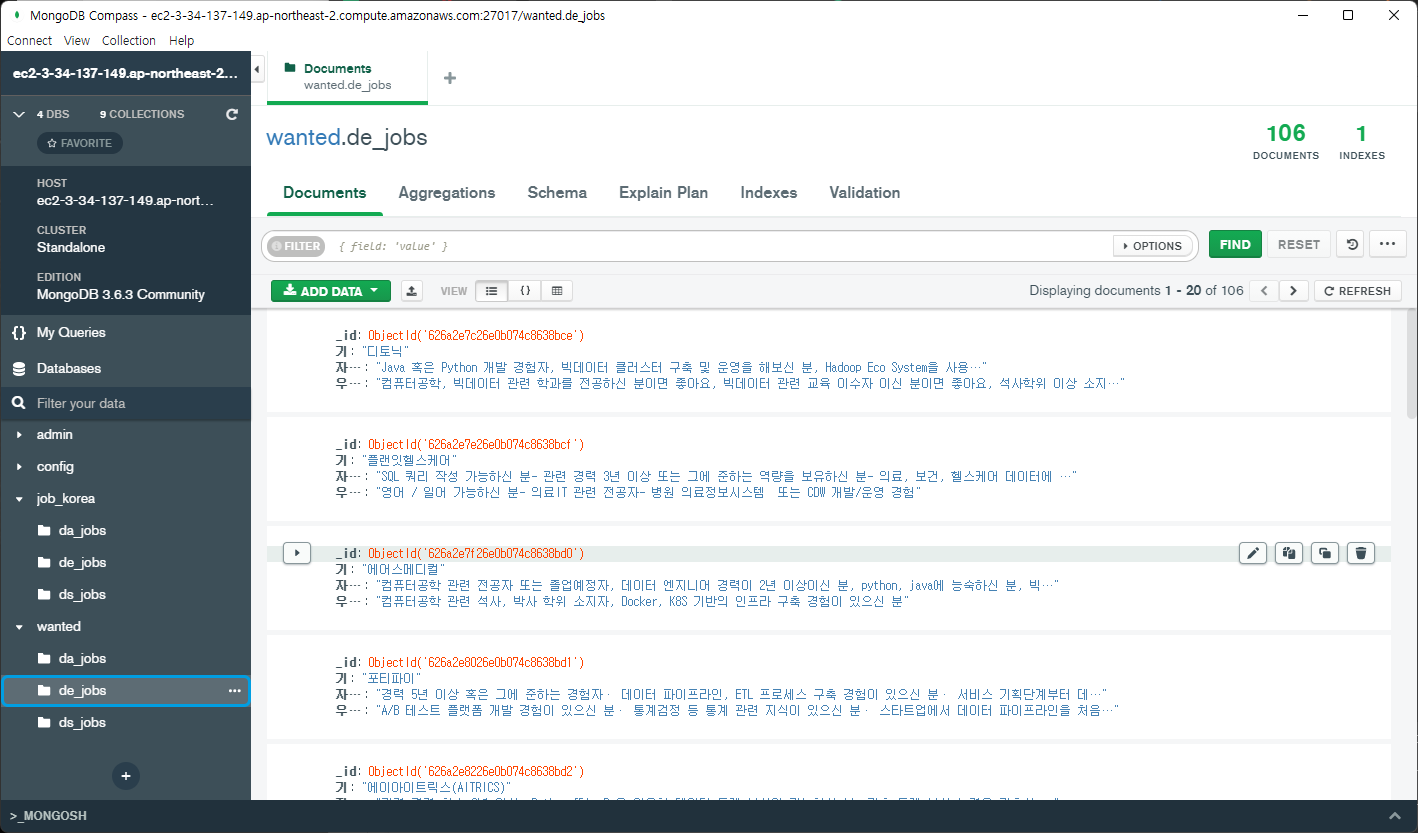

# 데이터 사이언티스트

In [ ]:
driver = get_chrome_driver()
driver.get("https://www.wanted.co.kr/")
search_job_scroll(driver, "데이터 사이언티스트")

# 공고 리스트 뽑아내기 
# WebElement 객체로 저장된다.
postings = driver.find_elements(
    By.CSS_SELECTOR,
    'ul.clearfix > li'
)

# 공고 리스트에서 innerHTML 추출
post_list = []
for post in postings:
    post_list.append((post).get_attribute("innerHTML"))

# 각 공고의 innerHTML 파싱 진행
po_list = []
for po in post_list:
    po_list.append(BeautifulSoup(po,'html.parser'))

# 파싱된 리스트에서 각 공고 링크만 추출
links = []
for p in po_list:
    temp_link = p.select_one("div.Card_className__u5rsb > a")['href']
    links.append(f"https://www.wanted.co.kr{temp_link}")

print(len(links))

doc_list = []

for link in links:
    driver.get(f"{link}")
    
    try:
        # 회사명
        company = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/section[2]/div[1]/h6/a')
        # 자격요건
        requirement = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[3]/span')
        # 우대사항
        prefer = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[4]/span')
    except:
        continue
        
    company_name = company.get_attribute("innerHTML")
    requirement_text = requirement.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    prefer_text = prefer.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    
    doc_list.append({"기업" : company_name, "자격요건" : requirement_text, "우대사항": prefer_text})
    doc = {
        "기업" : company_name,
        "자격요건" : requirement_text,
        "우대사항": prefer_text
    }
    db.ds_jobs.insert_one(doc)
    time.sleep(0.3)

driver.quit()
print(doc_list)

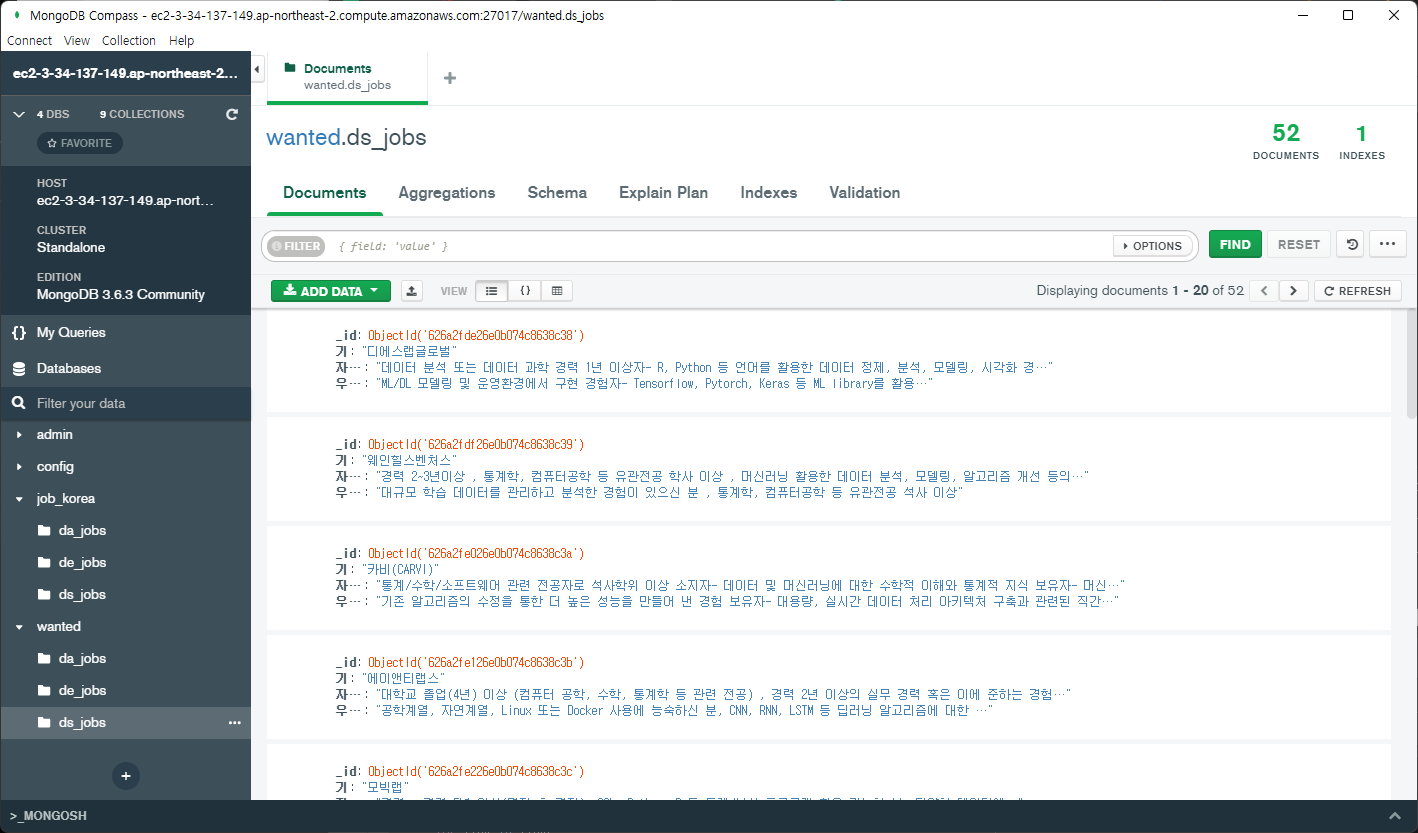

# 데이터 분석가

In [ ]:
driver = get_chrome_driver()
driver.get("https://www.wanted.co.kr/")
search_job_scroll(driver, "데이터 분석가")

# 공고 리스트 뽑아내기 
# WebElement 객체로 저장된다.
postings = driver.find_elements(
    By.CSS_SELECTOR,
    'ul.clearfix > li'
)

# 공고 리스트에서 innerHTML 추출
post_list = []
for post in postings:
    post_list.append((post).get_attribute("innerHTML"))

# 각 공고의 innerHTML 파싱 진행
po_list = []
for po in post_list:
    po_list.append(BeautifulSoup(po,'html.parser'))

# 파싱된 리스트에서 각 공고 링크만 추출
links = []
for p in po_list:
    temp_link = p.select_one("div.Card_className__u5rsb > a")['href']
    links.append(f"https://www.wanted.co.kr{temp_link}")

print(len(links))

doc_list = []

for link in links:
    driver.get(f"{link}")
    
    try:
        # 회사명
        company = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/section[2]/div[1]/h6/a')
        # 자격요건
        requirement = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[3]/span')
        # 우대사항
        prefer = driver.find_element_by_xpath('//*[@id="__next"]/div[3]/div[1]/div[1]/div[1]/div[2]/section/p[4]/span')
    except:
        continue
        
    company_name = company.get_attribute("innerHTML")
    requirement_text = requirement.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    prefer_text = prefer.get_attribute("innerHTML")[1:].strip().replace("•",",").replace("<br>","")
    
    doc_list.append({"기업" : company_name, "자격요건" : requirement_text, "우대사항": prefer_text})
    doc = {
        "기업" : company_name,
        "자격요건" : requirement_text,
        "우대사항": prefer_text
    }
    db.da_jobs.insert_one(doc)
    time.sleep(0.3)

driver.quit()
print(doc_list)

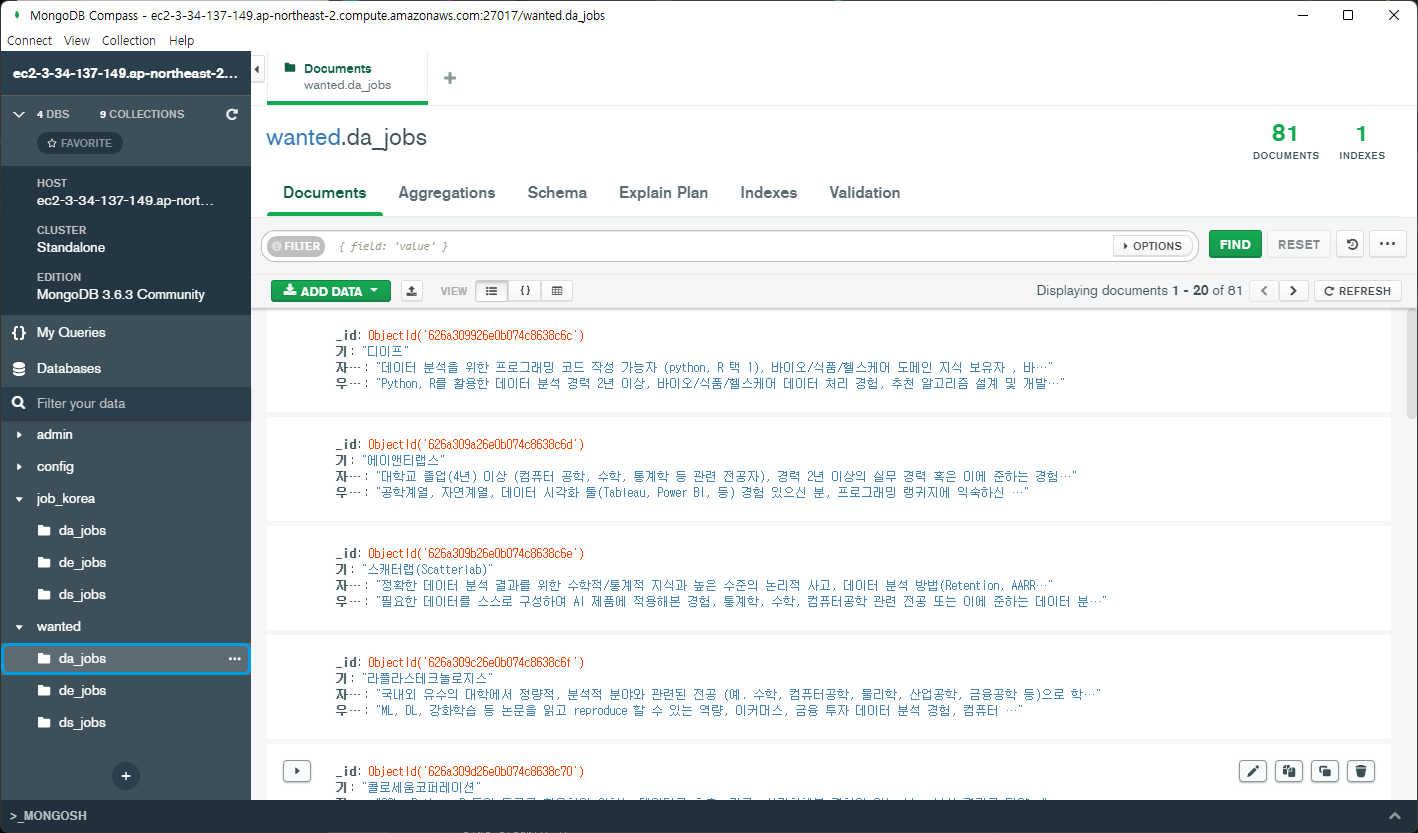